In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

### Загрузим датасет с машинами. Цель - верно восстанавливать для каждой из них цену продажи!

In [77]:
data = pd.read_csv('autos.csv')

data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [78]:
### Колонка с тергетом - "selling price"

X = data.drop("selling_price", axis=1)
y = data["selling_price"]

### Будем замерять MSLE!
### Поэтому прологарифмируем таргет
### А после оптимизируем MSE

y = y.apply(np.log1p)

In [79]:
### Разделим выборку на трейн и тест!

from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

__Задание__ 

Реализуйте свой MeanTargetEncoder с добавленем некоторого шума!

Однажды в лекционном материале, обсуждая счетчики, мы говорили с вами о том, что из-за них модели могут переобучаться. Один из способов бороться с этим - валидировать расчеты среднего таргета (стратегия отложенной выборки / расчеты на кросс-валидации). Но есть еще проще!

Можно просто к значению счетчика добавить случайный шум (зашумить данные)!

Напомним, что рассчитываться новые признаки должны по такой формуле:

$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]} + C * \epsilon
$$


Пусть шум будет случайной величиной из нормального стандартного распределения, то есть $\epsilon \sim N(0, 1) $, а $ C = 0.006$.

Создавай свой класс-трансформер, наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`. Трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и список из числовых признаков. На выходе должен получиться датасет того же размера с измененными категориальными признаками

In [94]:
object_cols = ['name', 'year', 'fuel', 'seller_type', 'transmission', 'owner']
num_cols = ['km_driven']

X.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,141000,Diesel,Individual,Manual,Second Owner


In [104]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoderNoise(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical, numeric):        
        self.categorical = categorical
        self.numeric = numeric
    
    def fit(self, X, y):
        X_fit = X.copy()
        y_fit = y.copy()
        
        X_with_target = pd.concat((X_fit, y_fit), axis=1)
        
        ### Посчитаем на валидации средние значения таргета
        self.dict_of_means = {
            col : X_with_target.groupby(col)['selling_price'].mean() + (np.random.random_sample((X_with_target[col].nunique(),)) * 0.006)
            for col in self.categorical
        }

        return self
        
    def transform(self, X):        
        X_ = X.copy()    
    
        for col in self.categorical:
            X_[col] = X_[col].map(self.dict_of_means[col])
                
#                 mean_value = transformer.dict_of_means[col].values.mean()
                
#                 X_[col] = X_[col].fillna(mean_value)

            X_[col] = X_[col].fillna(0)
            
        return X_

In [105]:
### Проверка работы трансформера

np.random.seed(1)
transformer = MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)

transformer.fit(X_train, y_train)

train = transformer.transform(X_train)
test = transformer.transform(X_test)

train.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
3294,13.475038,13.442772,50000,13.093929,12.623612,13.774849,12.978311
2290,12.118159,11.915769,70000,12.453797,12.623612,13.774849,12.978311
874,12.303707,13.338391,50000,12.453797,12.623612,12.643187,12.978311
1907,12.487258,13.060457,92198,12.453797,13.148980,12.643187,12.466180
3244,12.395613,12.860981,3240,12.453797,12.623612,12.643187,12.466180


Обучите несколько деревьев, перебирая максимальную глубину алгоритма из списка `max_depth_list`, а остальные параметры оставьте дефолтными. Выведите лучшее значение гиперпараметра. Постройте график зависимости MSLE на тестовой выборке от значения гиперпараметра. Воспользуйтесь `Pipeline` без `GridSearch`. Проделайте то же самое с `min_samples_split`, `min_impurity_decrease`, `max_leaf_nodes`. (по 2б на каждый параметр)

In [106]:
max_depth_list = [3, 5, 8, 12]
min_samples_split_list = [10, 50, 100, 500]
min_impurity_decrease_list = [0, 0.1, 0.15, 0.2]
max_leaf_nodes_list = [100, 200, 500]

3 0.796829214489203
5 1.442072604837312
8 1.9891705360380953
12 1.983189816784816


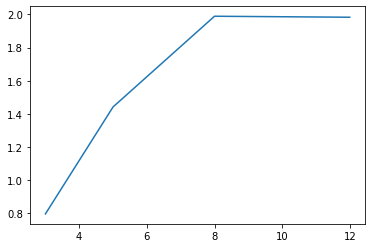

In [107]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

np.random.seed(1)

msle = {}

for max_depth in max_depth_list:
    pipe = Pipeline([("custom_transformer",
                      MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),


                     ("decision_tree", 
                      DecisionTreeRegressor(max_depth=max_depth))])

    pipe.fit(X_train, y_train)
    
    test_preds = pipe.predict(X_test)
    score= np.mean((test_preds - y_test)**2)
    
    print(max_depth, score)
    
    msle[max_depth] = score
    
plt.plot(msle.keys(),msle.values())





10 1.430834490523201
50 1.437751376583023
100 0.9522930653961675
500 0.8076747956646467


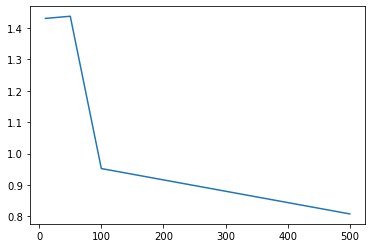

In [86]:
msle = {}

for min_samples_split in min_samples_split_list:
    pipe = Pipeline([("custom_transformer",
                      MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),


                     ("decision_tree", 
                      DecisionTreeRegressor(min_samples_split=min_samples_split))])

    pipe.fit(X_train, y_train)
    
    test_preds = pipe.predict(X_test)
    score= np.mean((test_preds - y_test)**2)
    
    print(min_samples_split, score)
    
    msle[min_samples_split] = score
    
plt.plot(msle.keys(),msle.values())

0 1.9806902134312987
0.1 0.5204871413036616
0.15 0.5204871413036546
0.2 0.5204871413036657


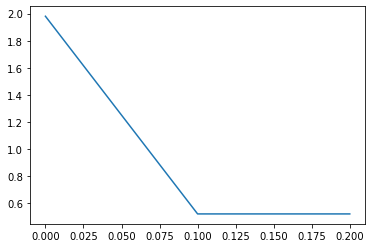

In [87]:
msle = {}

for min_impurity_decrease in min_impurity_decrease_list:
    pipe = Pipeline([("custom_transformer",
                      MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),


                     ("decision_tree", 
                      DecisionTreeRegressor(min_impurity_decrease=min_impurity_decrease))])

    pipe.fit(X_train, y_train)
    
    test_preds = pipe.predict(X_test)
    score= np.mean((test_preds - y_test)**2)
    
    print(min_impurity_decrease, score)
    
    msle[min_impurity_decrease] = score
    
plt.plot(msle.keys(),msle.values())

100 1.988201227126332
200 1.9843941843779893
500 1.9810626263695974


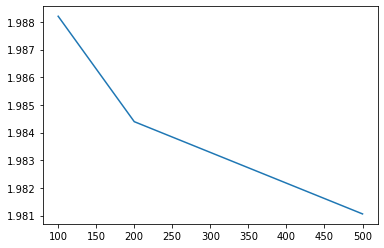

In [88]:
msle = {}

for max_leaf_nodes in max_leaf_nodes_list:
    pipe = Pipeline([("custom_transformer",
                      MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),


                     ("decision_tree", 
                      DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes))])

    pipe.fit(X_train, y_train)
    
    test_preds = pipe.predict(X_test)
    score= np.mean((test_preds - y_test)**2)
    
    print(max_leaf_nodes, score)
    
    msle[max_leaf_nodes] = score
    
plt.plot(msle.keys(),msle.values())

Подберите лучшую комбинацию параметров, используя `GridSearchCV` и набор массивов значений параметров из предыдущего задания. Для лучшей комбинации посчитайте MSLE на тестовой выборке. Получились ли лучшие параметры такими же, как если бы вы подбирали их по-отдельности при остальных гиперпараметрах по умолчанию (предыдущее задание)? (2б)

In [108]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "decision_tree__max_depth": [3, 5, 8, 12],
    "decision_tree__min_samples_split": [10, 50, 100, 500],
    "decision_tree__min_impurity_decrease": [0, 0.1, 0.15, 0.2],
    "decision_tree__max_leaf_nodes": [100, 200, 500]
}
np.random.seed(1)

pipe = Pipeline([("custom_transformer",
                      MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),


                     ("decision_tree", 
                      DecisionTreeRegressor())])

search = GridSearchCV(pipe, 
                      param_grid, 
                      scoring='neg_mean_squared_error'
                      )

search.fit(X_train, y_train)





GridSearchCV(estimator=Pipeline(steps=[('custom_transformer',
                                        MeanTargetEncoderNoise(categorical=['name',
                                                                            'year',
                                                                            'fuel',
                                                                            'seller_type',
                                                                            'transmission',
                                                                            'owner'],
                                                               numeric=['km_driven'])),
                                       ('decision_tree',
                                        DecisionTreeRegressor())]),
             param_grid={'decision_tree__max_depth': [3, 5, 8, 12],
                         'decision_tree__max_leaf_nodes': [100, 200, 500],
                         'decision_tree__min_impurity_decrease': [0, 0.1, 0.15,
                                                                  0.2],
                         'decision_tree__min_samples_split': [10, 50, 100,
                                                              500]},
             scoring='neg_mean_squared_error')

In [109]:
print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

print(f"Качество лучшей модели на финальном тесте: {search.score(X_test, y_test)}")

Best parameter (CV score=-0.57206):
{'decision_tree__max_depth': 12, 'decision_tree__max_leaf_nodes': 500, 'decision_tree__min_impurity_decrease': 0.15, 'decision_tree__min_samples_split': 50}
Качество лучшей модели на финальном тесте: -0.5204871413036717
